In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split


In [36]:
# pd.set_option('display.max_rows', None)

In [37]:
df_intern = pd.read_csv('../data/madrid/Viajeros pernoctaciones/viajeros_internacional.csv', sep= ';')

In [38]:
df_intern.head()

,País de residencia,Tipo de dato,Periodo,Total
0,Total,Dato base,2023M05,8.218.334
1,Total,Dato base,2023M04,7.235.055
2,Total,Dato base,2023M03,5.257.076
3,Total,Dato base,2023M02,4.321.152
4,Total,Dato base,2023M01,4.147.345


In [39]:
df_intern = df_intern.dropna(subset=['Total'])


In [40]:
df_intern.dtypes

País de residencia    object
Tipo de dato          object
Periodo               object
Total                 object
dtype: object

In [41]:
df_intern['Total'] = df_intern['Total'].str.replace(',', '.')
df_intern['Total'] = pd.to_numeric(df_intern['Total'], errors='coerce')


In [42]:
df_intern['País de residencia'].unique()

array(['Total', 'Alemania', 'Bélgica', 'Francia', 'Irlanda', 'Italia',
       'Países Bajos', 'Países Nórdicos', 'Portugal', 'Reino Unido',
       'Rusia', 'Suiza', 'Resto de Europa', 'Estados Unidos de América',
       'Resto América', 'Resto del Mundo'], dtype=object)

In [43]:
df_total = df_intern[df_intern['País de residencia'] == 'Total']


In [44]:
df_total.head()

,País de residencia,Tipo de dato,Periodo,Total
0,Total,Dato base,2023M05,NaN
1,Total,Dato base,2023M04,NaN
2,Total,Dato base,2023M03,NaN
3,Total,Dato base,2023M02,NaN
4,Total,Dato base,2023M01,NaN


In [45]:
# limpiar df solo con paises sin totales
df_intern = df_intern[df_intern['País de residencia'] != 'Total']

In [46]:
df_intern.head()

,País de residencia,Tipo de dato,Periodo,Total
368,Alemania,Dato base,2023M05,NaN
369,Alemania,Dato base,2023M04,NaN
370,Alemania,Dato base,2023M03,673.584
371,Alemania,Dato base,2023M02,509.883
372,Alemania,Dato base,2023M01,478.258


In [47]:
# sacar solo dato base sin acumulados
df_foreigner_clean = df_intern[df_intern['Tipo de dato'] == 'Dato base']

In [48]:
df_foreigner_clean.head()

,País de residencia,Tipo de dato,Periodo,Total
368,Alemania,Dato base,2023M05,NaN
369,Alemania,Dato base,2023M04,NaN
370,Alemania,Dato base,2023M03,673.584
371,Alemania,Dato base,2023M02,509.883
372,Alemania,Dato base,2023M01,478.258


In [49]:
# cambiar tipo fecha
df_foreigner_clean['Periodo'] = pd.to_datetime(df_foreigner_clean['Periodo'], format='%YM%m')



C:\Users\34680\AppData\Local\Temp\ipykernel_9172\508254461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foreigner_clean['Periodo'] = pd.to_datetime(df_foreigner_clean['Periodo'], format='%YM%m')


In [50]:
#  Elimina el formato hora
df_foreigner_clean['Periodo'] = df_foreigner_clean['Periodo'].dt.strftime('%Y-%m-%d')


C:\Users\34680\AppData\Local\Temp\ipykernel_9172\2209030397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foreigner_clean['Periodo'] = df_foreigner_clean['Periodo'].dt.strftime('%Y-%m-%d')


In [51]:
df_foreigner_clean = df_foreigner_clean.sort_values(by='Periodo', ascending=True)

In [52]:


# g = sns.FacetGrid(df_foreigner_clean, col='País de residencia', col_wrap=3)
# g.map(sns.barplot, 'Periodo', 'Total')
# plt.show()


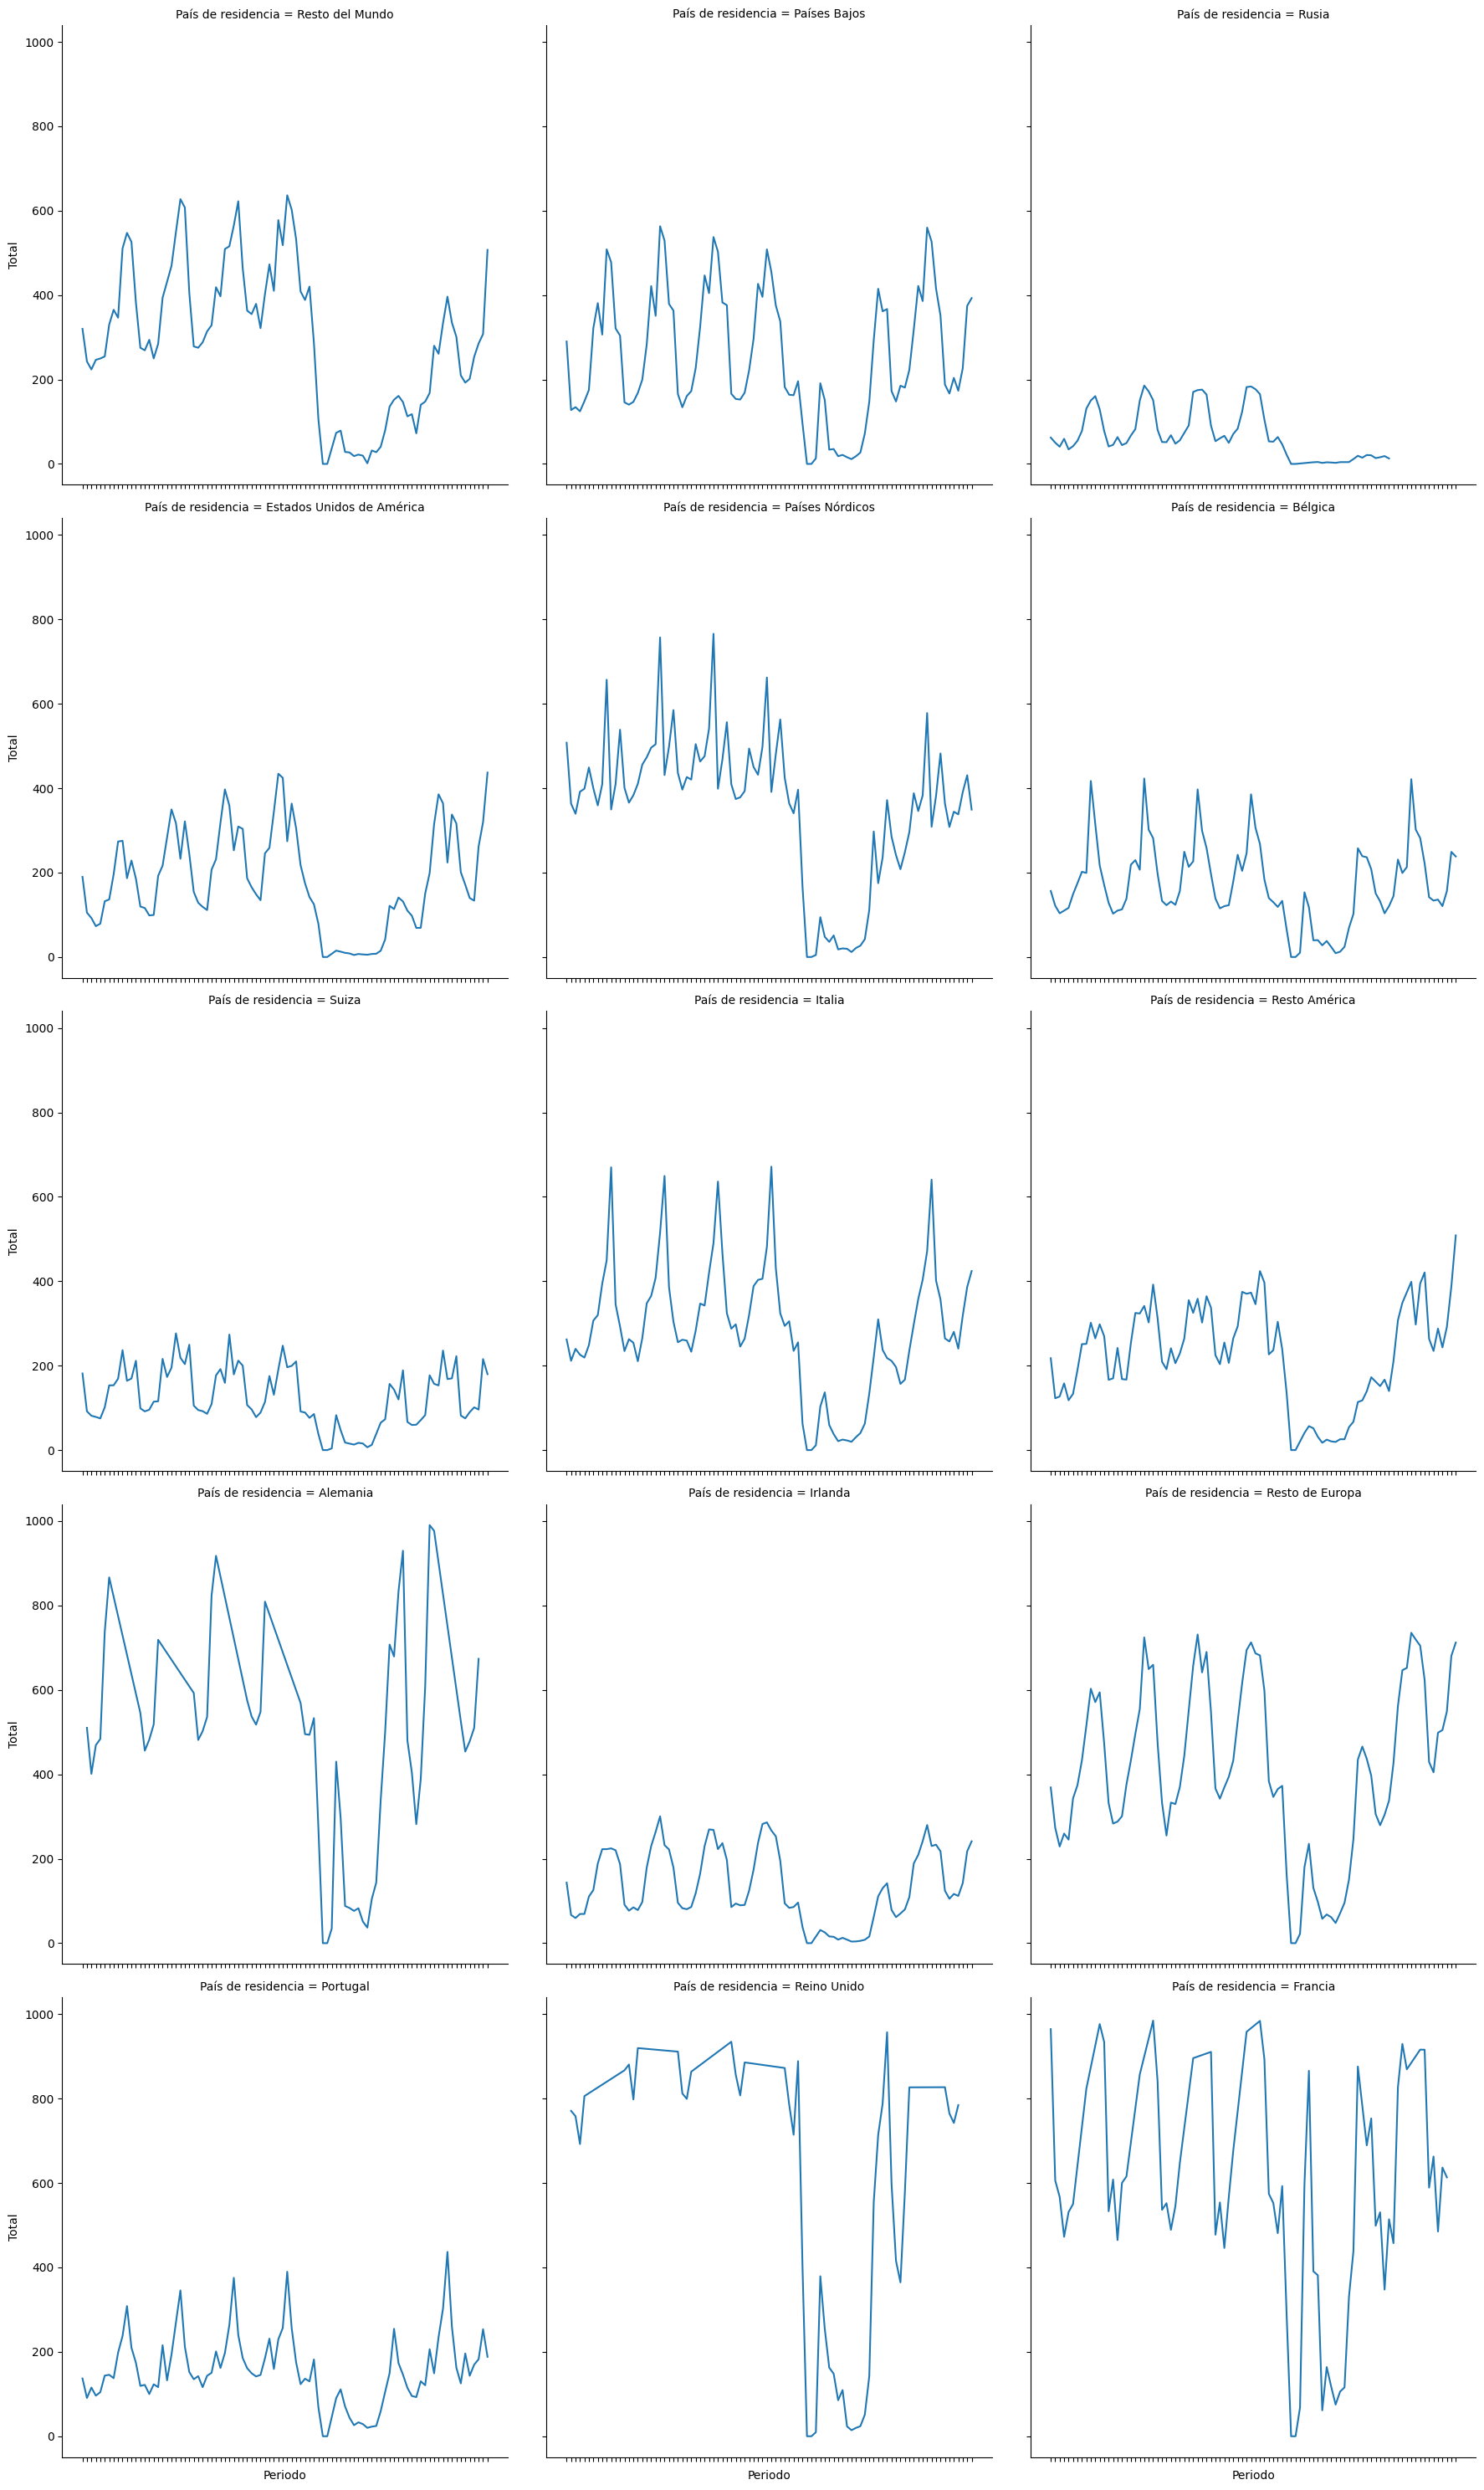

In [53]:
g = sns.FacetGrid(data=df_foreigner_clean, col='País de residencia', col_wrap=3, height=6)
g.map(sns.lineplot, 'Periodo', 'Total')
g.set_xticklabels(rotation=45)
plt.show()


In [54]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_foreigner_clean, x='Periodo', y='Total', hue='País de residencia')
# plt.xticks(plt.xticks()[0][::10], rotation=45)
# plt.show()


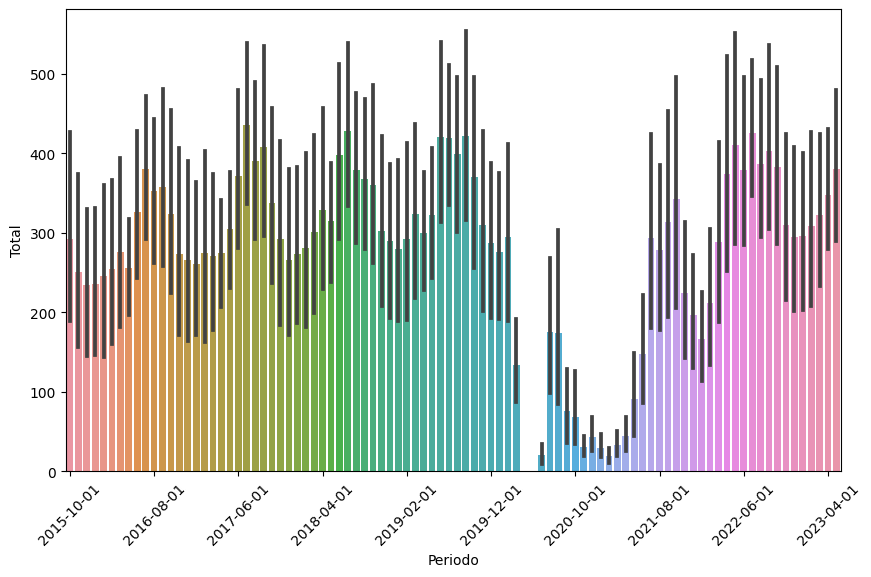

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_foreigner_clean, x='Periodo', y='Total', dodge=True,)
plt.xticks(plt.xticks()[0][::10], rotation=45)

plt.show()


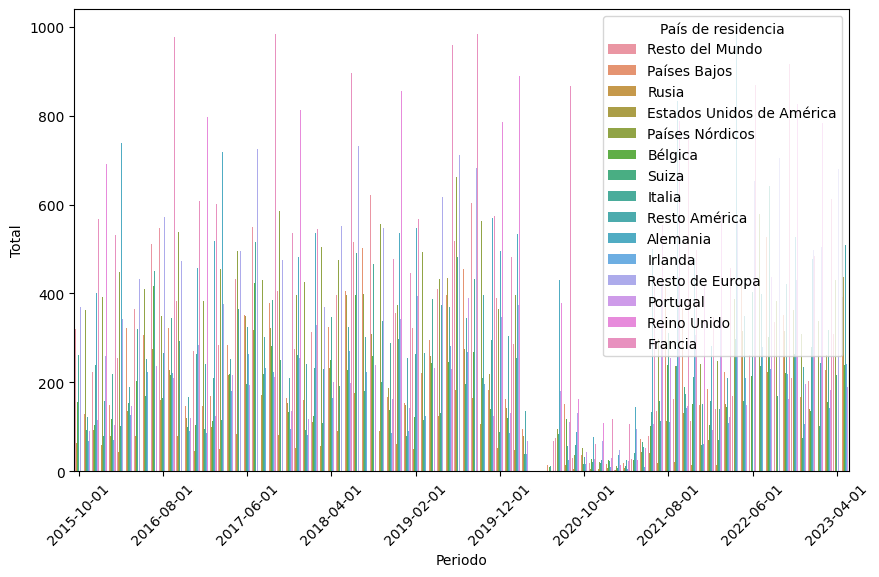

In [56]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_foreigner_clean, x='Periodo', y='Total', hue='País de residencia')
plt.xticks(plt.xticks()[0][::10], rotation=45)
ax.legend(title='País de residencia')
plt.show()





c:\Users\34680\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


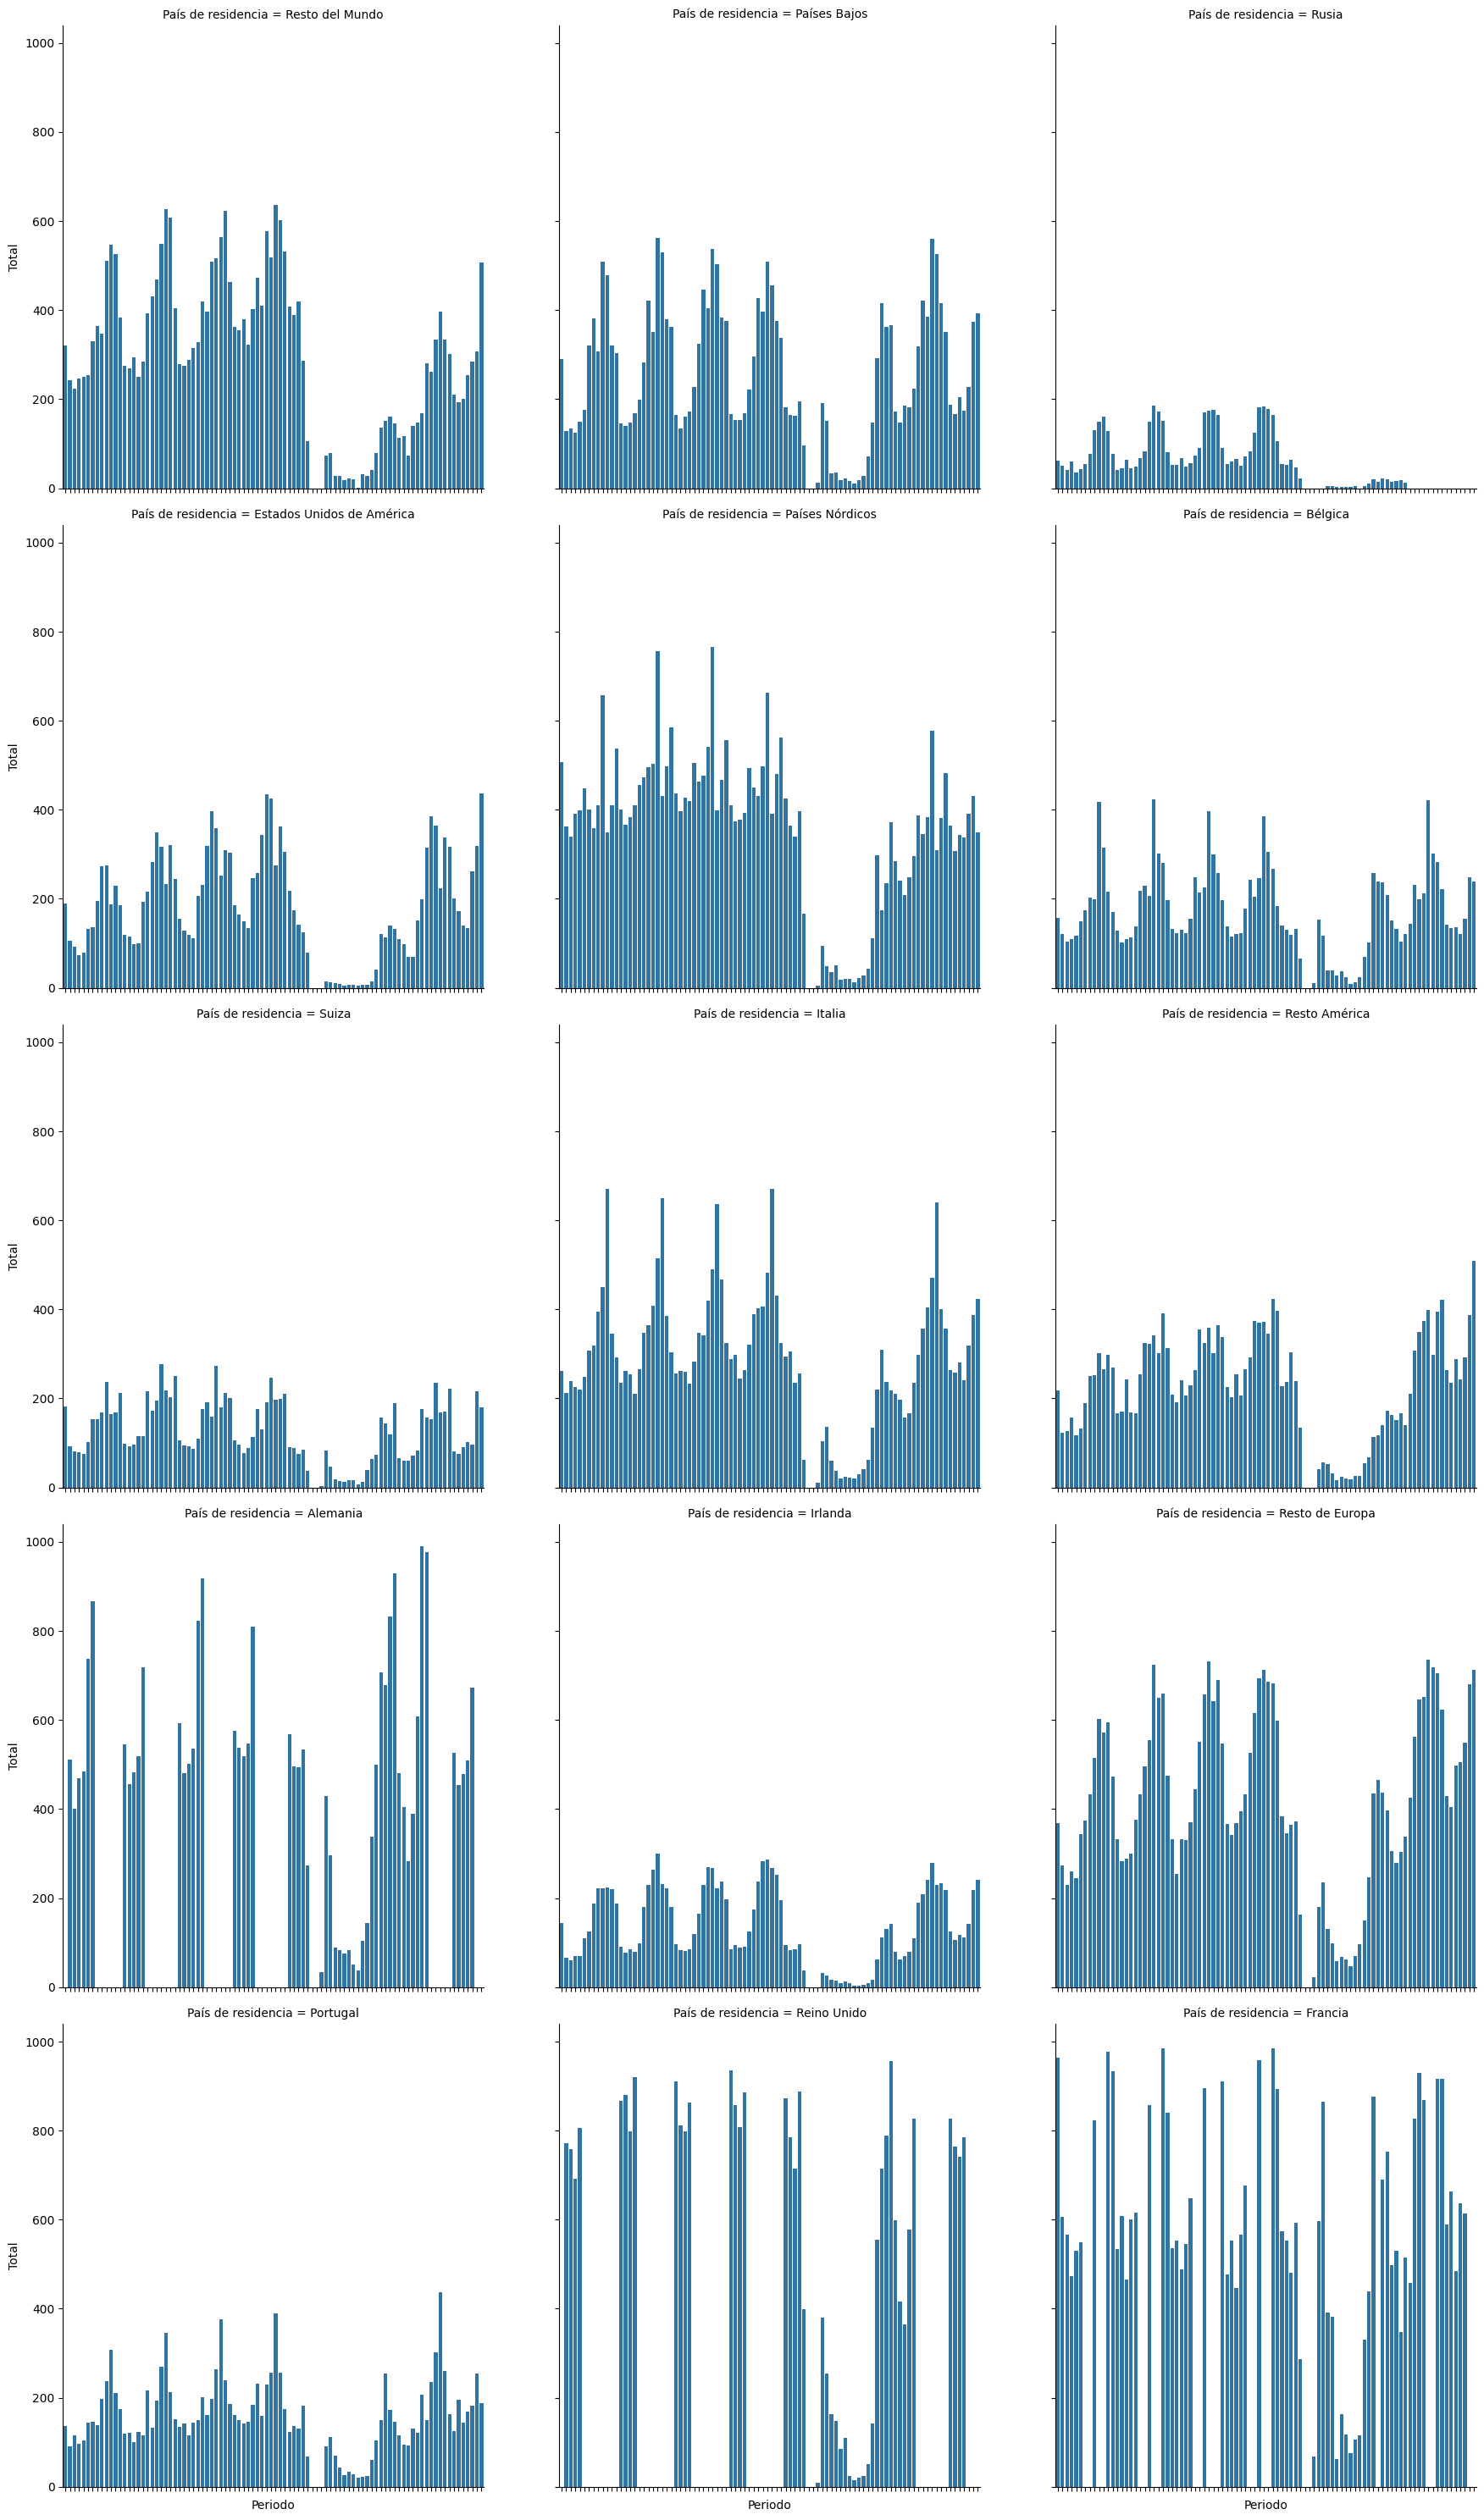

In [57]:
g = sns.FacetGrid(data=df_foreigner_clean, col='País de residencia', col_wrap=3, height=6)
g.map(sns.barplot, 'Periodo', 'Total', dodge=True)
g.set_xticklabels(rotation=45)
plt.show()


## Entrenamiento forecasting

In [58]:
df_foreigner_clean.head()

,País de residencia,Tipo de dato,Periodo,Total
5611,Resto del Mundo,Dato base,2015-10-01,320.081
2299,Países Bajos,Dato base,2015-10-01,290.035
3771,Rusia,Dato base,2015-10-01,62.414
4875,Estados Unidos de América,Dato base,2015-10-01,189.891
2667,Países Nórdicos,Dato base,2015-10-01,507.661


In [59]:
df_foreigner_clean[df_foreigner_clean['País de residencia'] =='Resto del Mundo' ]

,País de residencia,Tipo de dato,Periodo,Total
5611,Resto del Mundo,Dato base,2015-10-01,320.081
5610,Resto del Mundo,Dato base,2015-11-01,242.798
5609,Resto del Mundo,Dato base,2015-12-01,223.824
5608,Resto del Mundo,Dato base,2016-01-01,246.638
5607,Resto del Mundo,Dato base,2016-02-01,249.785
...,...,...,...,...
5524,Resto del Mundo,Dato base,2023-01-01,201.656
5523,Resto del Mundo,Dato base,2023-02-01,253.742
5522,Resto del Mundo,Dato base,2023-03-01,285.343
5521,Resto del Mundo,Dato base,2023-04-01,307.731


In [60]:
df_foreigner_clean = df_foreigner_clean.reset_index(drop=True)

In [61]:
df_foreigner_clean = df_foreigner_clean.dropna()

In [62]:
df_foreigner_clean['País de residencia'].unique()

array(['Resto del Mundo', 'Países Bajos', 'Rusia',
       'Estados Unidos de América', 'Países Nórdicos', 'Bélgica', 'Suiza',
       'Italia', 'Resto América', 'Irlanda', 'Resto de Europa',
       'Portugal', 'Francia', 'Alemania', 'Reino Unido'], dtype=object)

# Crear df por pais para entreno

In [63]:
def df_procesado(df):
    df['Periodo'] = pd.to_datetime(df['Periodo'])
    # Extrae las columnas de mes, año y día
    df['Mes'] = df['Periodo'].dt.month
    df['Año'] = df['Periodo'].dt.year
    df['Día'] = df['Periodo'].dt.day

# Obtener la lista de países únicos
countries = df_foreigner_clean['País de residencia'].unique()

# Crear una lista para almacenar los nombres de los DataFrames
df_names = []

# Crear una variable separada para cada país
for country in countries:
    # Crear el nombre de la variable
    var_name = 'df_' + country.lower().replace(' ', '_')
    
    # Crear el DataFrame para el país
    df_country = df_foreigner_clean.loc[df_foreigner_clean['País de residencia'] == country]
    
    # Eliminar la columna 'Tipo de dato'
    df_country = df_country.drop('Tipo de dato', axis=1)
    
    # Aplicar la función df_procesado al DataFrame
    df_procesado(df_country)
    
    # Asignar el DataFrame a la variable
    globals()[var_name] = df_country
    
    # Agregar el nombre del DataFrame a la lista
    df_names.append(var_name)





In [64]:
# limpiar covid
df_rusia

,País de residencia,Periodo,Total,Mes,Año,Día
2,Rusia,2015-10-01,62.414,10,2015,1
20,Rusia,2015-11-01,50.384,11,2015,1
35,Rusia,2015-12-01,40.739,12,2015,1
57,Rusia,2016-01-01,59.514,1,2016,1
74,Rusia,2016-02-01,34.455,2,2016,1
...,...,...,...,...,...,...
1091,Rusia,2021-10-01,20.385,10,2021,1
1103,Rusia,2021-11-01,13.739,11,2021,1
1114,Rusia,2021-12-01,15.886,12,2021,1
1129,Rusia,2022-01-01,18.563,1,2022,1


# DF usados para entrenar sin sesgo covid

In [65]:
# Crear una lista para almacenar los nombres de los DataFrames limpios
df_clean_names = []

# Iterar sobre cada país
for country in countries:
    # Crear el nombre de la variable
    var_name = 'df_' + country.lower().replace(' ', '_')
    
    # Obtener el DataFrame para el país
    df_country = globals()[var_name]
    
    # Eliminar las filas donde la columna 'Año' es mayor o igual a 2020
    df_country_clean = df_country[df_country['Año'] < 2020]
    
    # Crear el nombre de la variable para el DataFrame limpio
    var_name_clean = var_name + '_clean'
    
    # Asignar el DataFrame limpio a la variable
    globals()[var_name_clean] = df_country_clean
    
    # Agregar el nombre del DataFrame limpio a la lista
    df_clean_names.append(var_name_clean)


In [66]:


# Definir la cuadrícula de hiperparámetros
hyperparameters = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_models_dict = {}

for df_name in df_clean_names:
    df = globals()[df_name]
    
    # Preparar los datos para el modelo
    X = df.drop(['Total', 'Periodo','País de residencia'], axis=1)
    y = df['Total']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Crear el modelo RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)

    # Crear el objeto GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=hyperparameters, cv=5)

    # Entrenar el modelo con GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtener los mejores parámetros
    best_params = grid_search.best_params_

    # Entrenar el modelo RandomForestRegressor con los mejores parámetros
    rf_best = RandomForestRegressor(**best_params, random_state=0)
    rf_best.fit(X_train, y_train)

    # Guardar el mejor modelo en el diccionario
    best_models_dict[df_name] = rf_best



In [81]:
best_models_dict

{'df_resto_del_mundo_clean': RandomForestRegressor(max_depth=10, n_estimators=300, random_state=0),
 'df_países_bajos_clean': RandomForestRegressor(max_depth=10, random_state=0),
 'df_rusia_clean': RandomForestRegressor(max_depth=10, n_estimators=400, random_state=0),
 'df_estados_unidos_de_américa_clean': RandomForestRegressor(max_depth=10, n_estimators=400, random_state=0),
 'df_países_nórdicos_clean': RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=0),
 'df_bélgica_clean': RandomForestRegressor(max_depth=10, random_state=0),
 'df_suiza_clean': RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=0),
 'df_italia_clean': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=0),
 'df_resto_américa_clean': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=0),
 'df_irlanda_clean': RandomForestRegressor(max_depth=10, min_samples_split=5, 

In [105]:
df_metricas

,Country,Model,max_depth,min_samples_split,n_estimators
0,Resto_del_mundo,RandomForestRegressor,10,None,300


In [113]:
data_params = {'Country': ['Resto_del_mundo', 'Países_bajos', 'Rusia', 'EEUU', 'P. Nordicos', 'Belgica', 'Suiza', 'Italia', 'Resto de Ámerica', 'Irlanda', 'Resto de europa', 'Portugar', 'Francia', 'Alemania', 'Reino_unido'],
        'Model': ['RandomForestRegressor'] * 15,
        'max_depth': [10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10],
        'min_samples_split': [None, None, None, None, 10, None, 10, None, None, 5, None, None, None, None, 5],
        'n_estimators': [300, None, 400, 400, 300, None, 300, 200, 200,None,None,None,None,None,None]}

df_params = pd.DataFrame(data_params)


df_params

,Country,Model,max_depth,min_samples_split,n_estimators
0,Resto_del_mundo,RandomForestRegressor,10,NaN,300.0
1,Países_bajos,RandomForestRegressor,10,NaN,NaN
2,Rusia,RandomForestRegressor,10,NaN,400.0
3,EEUU,RandomForestRegressor,10,NaN,400.0
4,P. Nordicos,RandomForestRegressor,10,10.0,300.0
5,Belgica,RandomForestRegressor,10,NaN,NaN
6,Suiza,RandomForestRegressor,10,10.0,300.0
7,Italia,RandomForestRegressor,10,NaN,200.0
8,Resto de Ámerica,RandomForestRegressor,20,NaN,200.0
9,Irlanda,RandomForestRegressor,10,5.0,NaN


# Metricas

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for df_name in df_clean_names:
    # Obtener el mejor modelo para el conjunto de datos actual
    rf_best = best_models_dict[df_name]
    
    # Preparar los datos para el modelo
    df = globals()[df_name]
    X = df.drop(['Total', 'Periodo','País de residencia'], axis=1)
    y = df['Total']
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Realizar predicciones con el mejor modelo
    y_pred = rf_best.predict(X_test)

    # Calcular el Error Cuadrático Medio (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Calcular la Raíz del Error Cuadrático Medio (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Calcular el Coeficiente de Determinación (R^2)
    r2 = r2_score(y_test, y_pred)

    # Calcular el Error Absoluto Medio (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Imprimir las métricas para el conjunto de datos actual
    print(f"{df_name}: MSE={mse:.2f}, RMSE={rmse:.2f}, R^2={r2:.2f}, MAE={mae:.2f}")



df_resto_del_mundo_clean: MSE=1974.48, RMSE=44.44, R^2=0.89, MAE=37.23
df_países_bajos_clean: MSE=347.74, RMSE=18.65, R^2=0.99, MAE=16.17
df_rusia_clean: MSE=71.85, RMSE=8.48, R^2=0.98, MAE=7.02
df_estados_unidos_de_américa_clean: MSE=1640.23, RMSE=40.50, R^2=0.88, MAE=31.78
df_países_nórdicos_clean: MSE=11108.20, RMSE=105.40, R^2=0.32, MAE=82.09
df_bélgica_clean: MSE=861.78, RMSE=29.36, R^2=0.92, MAE=18.36
df_suiza_clean: MSE=954.91, RMSE=30.90, R^2=0.79, MAE=25.27
df_italia_clean: MSE=4308.95, RMSE=65.64, R^2=0.83, MAE=43.63
df_resto_américa_clean: MSE=448.04, RMSE=21.17, R^2=0.94, MAE=18.37
df_irlanda_clean: MSE=153.68, RMSE=12.40, R^2=0.98, MAE=11.10
df_resto_de_europa_clean: MSE=1641.43, RMSE=40.51, R^2=0.96, MAE=34.38
df_portugal_clean: MSE=768.87, RMSE=27.73, R^2=0.87, MAE=20.90
df_francia_clean: MSE=1866.68, RMSE=43.21, R^2=0.90, MAE=37.84
df_alemania_clean: MSE=807.49, RMSE=28.42, R^2=0.81, MAE=21.80
df_reino_unido_clean: MSE=650.72, RMSE=25.51, R^2=0.80, MAE=21.78


In [114]:
data_metrics = {'Country': ['Resto_del_mundo', 'Países_bajos', 'Rusia', 'EEUU', 'P. Nordicos', 'Belgica', 'Suiza', 'Italia', 'Resto de Ámerica', 'Irlanda', 'Resto de europa', 'Portugar', 'Francia', 'Alemania', 'Reino_unido'],
        'MSE': [1974.48, 347.74, 71.85, 1640.23, 11108.20, 861.78, 954.91, 4308.95, 448.04, 153.68, 1641.43, 768.87, 1866.68, 807.49, 650.72],
        'RMSE': [44.44, 18.65, 8.48, 40.50, 105.40, 29.36, 30.90, 65.64, 21.17, 12.40, 40.51, 27.73, 43.21, 28.42,25.51],
        'R^2': [0.89,0.99,0.98,0.88,0.32,0.92,0.79,0.83,0.94,0.98,.96,.87,.90,.81,.80],
        'MAE': [37.23 ,16.17 ,7.02 ,31.78 ,82.09 ,18.36 ,25.27 ,43.63,18.37,11.10,34.38,20.90,37.84,21.80,21.78]}
df_metricas = pd.DataFrame(data_metrics)

In [115]:
df_metricas

,Country,MSE,RMSE,R^2,MAE
0,Resto_del_mundo,1974.48,44.44,0.89,37.23
1,Países_bajos,347.74,18.65,0.99,16.17
2,Rusia,71.85,8.48,0.98,7.02
3,EEUU,1640.23,40.50,0.88,31.78
4,P. Nordicos,11108.20,105.40,0.32,82.09
5,Belgica,861.78,29.36,0.92,18.36
6,Suiza,954.91,30.90,0.79,25.27
7,Italia,4308.95,65.64,0.83,43.63
8,Resto de Ámerica,448.04,21.17,0.94,18.37
9,Irlanda,153.68,12.40,0.98,11.10


In [91]:
predictions_dict = {}

for df_name, model in best_models_dict.items():
    # Preparar los datos de entrada para el modelo
    df = globals()[df_name]
    X = df.drop(['Total', 'Periodo','País de residencia'], axis=1)
    
    # Hacer las predicciones
    predictions = model.predict(X)
    
    # Crear un nuevo DataFrame con las predicciones
    predictions_df = pd.DataFrame(predictions, columns=['Predicciones'])
    
    # Guardar el nuevo DataFrame en el diccionario
    predictions_dict[df_name] = predictions_df




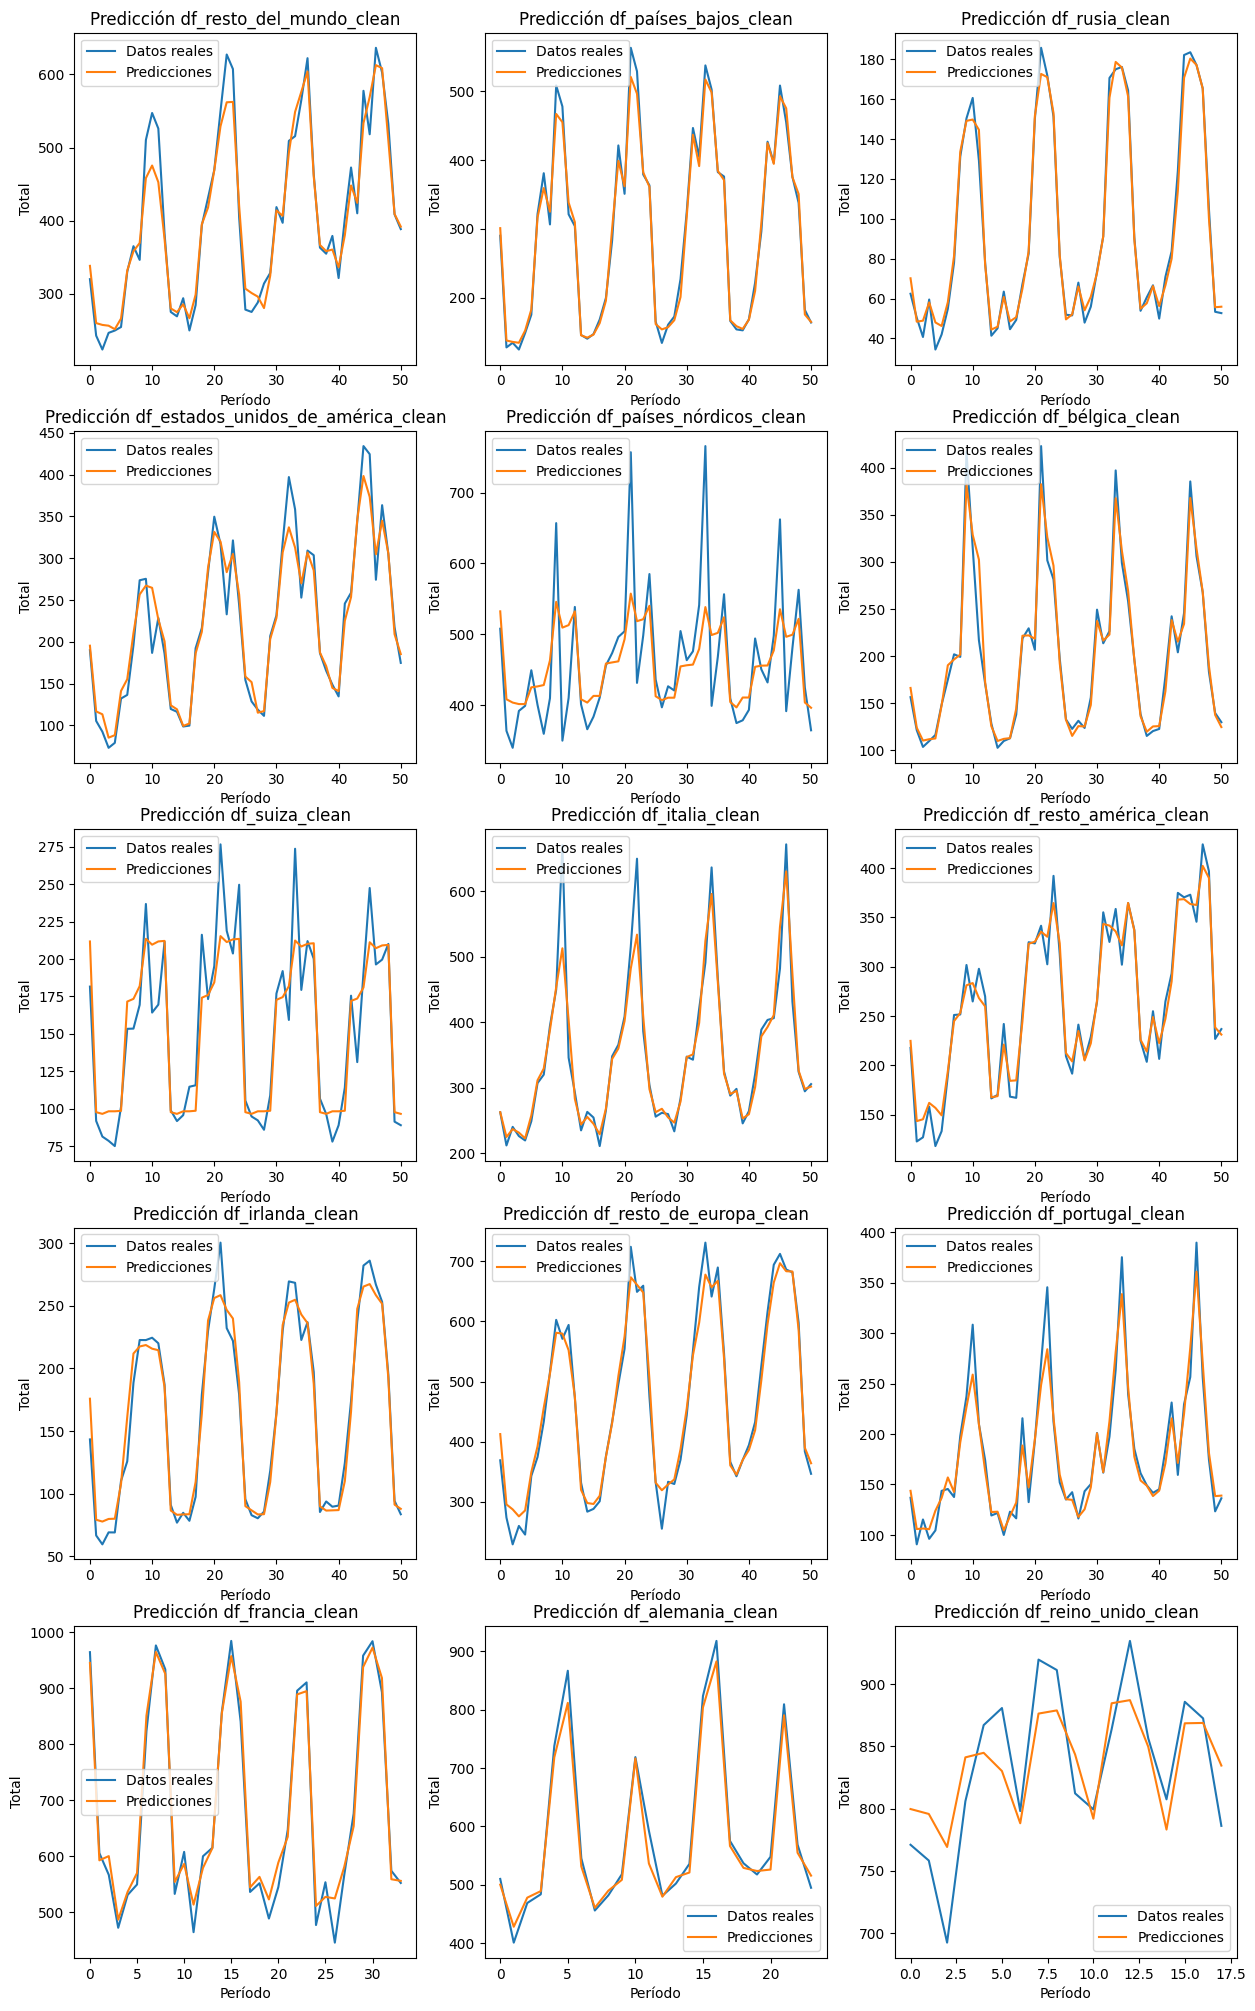

In [93]:
# Calcular el número de filas necesario para mostrar todos los gráficos
n_rows = int(np.ceil(len(predictions_dict) / 3))

# Crear la figura y los ejes
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

# Iterar sobre cada conjunto de datos en predictions_dict y df_names
for i, (df_name, predictions) in enumerate(predictions_dict.items()):
    # Calcular la fila y la columna correspondiente al gráfico actual
    row = i // 3
    col = i % 3
    
    # Obtener los datos reales y las predicciones
    real_data = globals()[df_name]['Total']
    predicted_data = predictions['Predicciones']
    
    # Restablecer los índices de real_data y predicted_data
    real_data = real_data.reset_index(drop=True)
    predicted_data = predicted_data.reset_index(drop=True)
    
    # Crear un DataFrame con los datos reales y las predicciones
    data = pd.DataFrame({'Datos reales': real_data, 'Predicciones': predicted_data})
    
    # Crear el gráfico en el eje correspondiente
    data.plot(ax=axes[row, col], kind='line')
    axes[row, col].set_xlabel('Período')
    axes[row, col].set_ylabel('Total')
    axes[row, col].set_title(f'Predicción {df_name}')

# Mostrar la figura
plt.show()


In [94]:
# pasarlo a array
predictions_array_dict = {}

for df_name, predictions in predictions_dict.items():
    # Convertir las predicciones a un array
    predictions_array = predictions['Predicciones'].values
    
    # Guardar el array en el diccionario
    predictions_array_dict[df_name] = predictions_array


## Visualizaciones de forecast Nacionalidad Europa 2028


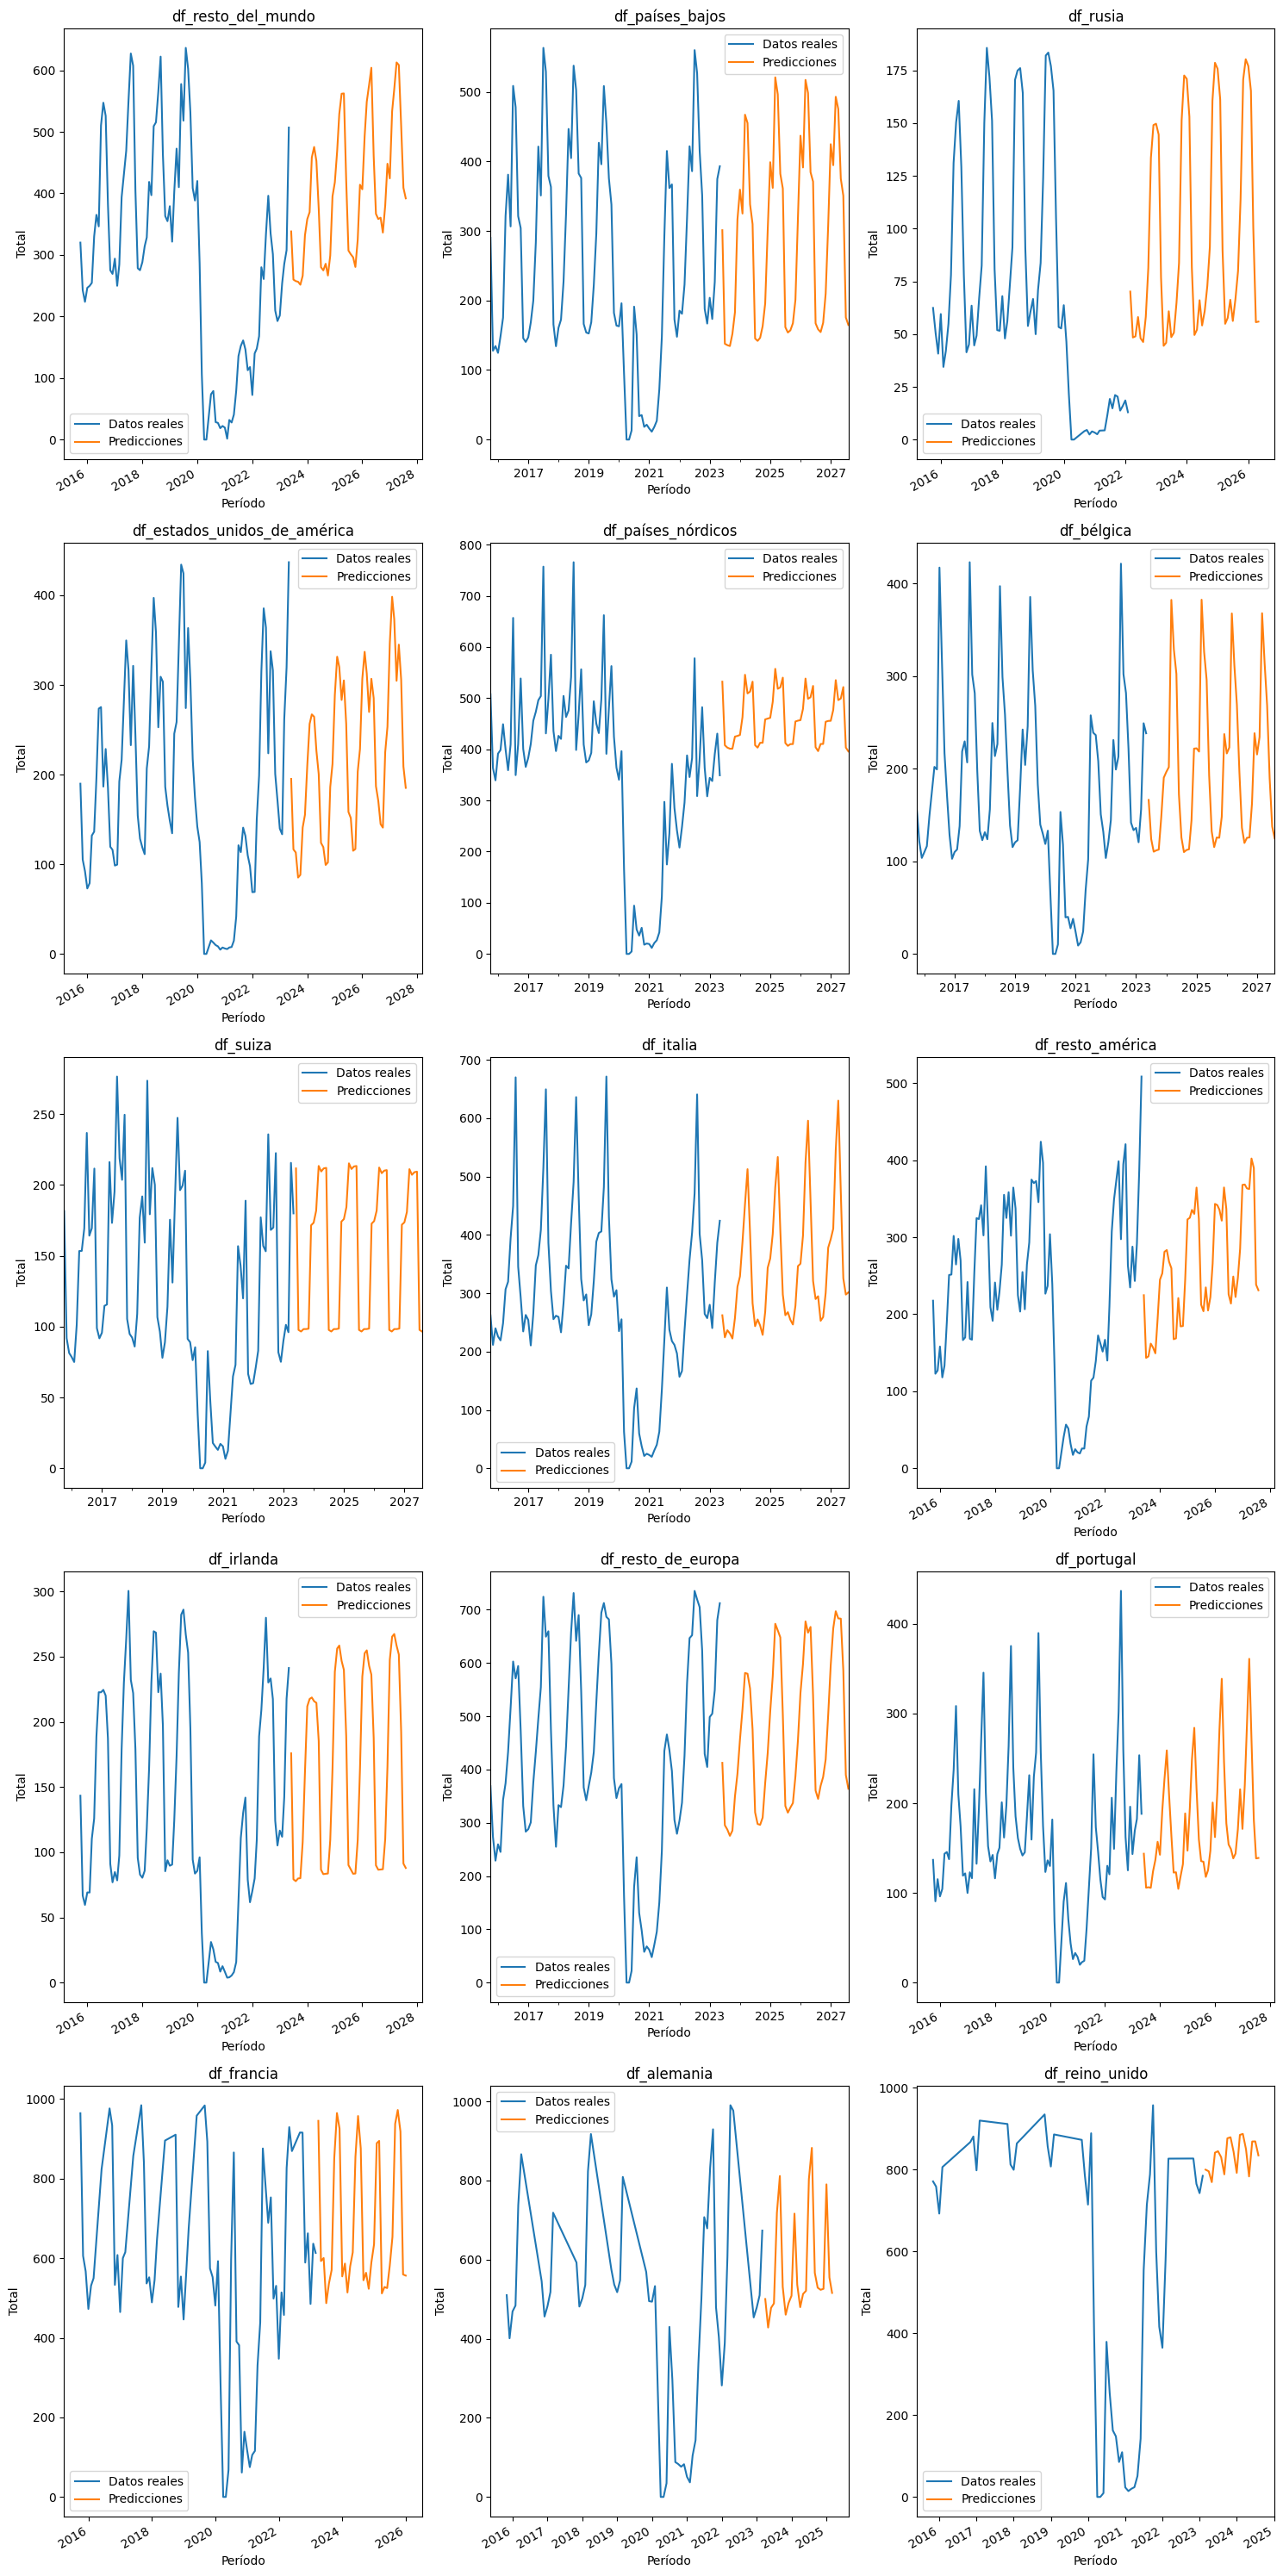

In [95]:
import matplotlib.pyplot as plt
from math import ceil

fig, axs = plt.subplots(ceil(len(df_names)/3), 3, figsize=(15, 30))
for i, name in enumerate(df_names):
    df = eval(name)
    # df.set_index('Periodo', inplace=True)
    data = pd.DataFrame({'Datos reales': df['Total'], 'Predicciones': pd.Series(predictions_array_dict[name + '_clean'], index=pd.date_range(start=df.index[-1], periods=len(predictions_array_dict[name + '_clean'])+1, freq='MS')[1:])})
    data.plot(ax=axs[i//3, i%3])
    axs[i//3, i%3].set_xlabel('Período')
    axs[i//3, i%3].set_ylabel('Total')
    axs[i//3, i%3].set_title(name)
plt.tight_layout()
plt.show()


In [96]:
for df_name, model in best_models_dict.items():
    # Crear el nombre del archivo
    filename = f"{df_name}_model.pkl"
    
    # Guardar el modelo en el archivo
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
